Let's construct an example of what happens when the columns of $x$ are: 
#1. not independent
#2. Correlated with the errors



#2

We expect that creating a model with a "missing" parameter should cause bias, let's explore an example using the social network  from p181 DSFS.

In the social network, we want to predict the number of minutes a user spends on the site using only a few parameters: the number of friends and the number of hours worked at their day job.  

Let's assume that:
    1. People who work more hours spend less time on the site. (negative correlation: work_hours and minutes)
    2. People with more friends tend to work more hours. (positive correlation: friends and work_hours)

We'll create some data with these properties and try to observe the appearance of bias in our estimate of the first beta parameter (in a model making predictions using only that parameter) vs (using all of the "true" parameters)

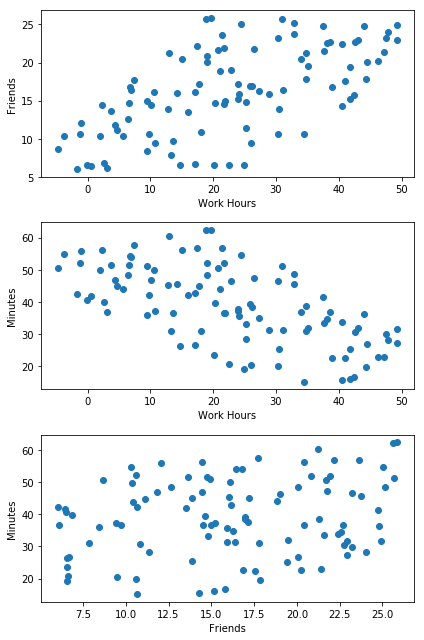

In [1]:
import random
from matplotlib import pyplot as plt
random.seed(1)


#+--------------===set "True" model parameters===-----------------+
betas = [2, -1]
alpha = 26
alphabetas = [alpha] + betas

#+----------------------===generate data===-----------------------+

#friends is random
friends_count = [(random.random()+0.3)*20 for _ in range(100)]

#positive and noisy linear relationship between friends and work hours
work_hours = [friend*(1.5) + (random.random()-0.5)*40 
              for friend in friends_count]     

#errors are random
errors  = [(random.random()+0.3)*4 for _ in friends_count]

#minutes constructed by model  m = \alpha + beta_0*friends + \beta_1*hours + error
minutes = [alpha+betas[0]*friends+betas[1]*hours + error 
           for friends,hours,error in zip(friends_count,work_hours,errors)]


ys = minutes
data  = zip([1 for _ in friends_count], friends_count, work_hours)

#+------------------------===plotting===--------------------------+ 

fig, axs = plt.subplots(3)

ax1,ax2,ax3 = axs

ax1.scatter(work_hours,friends_count)
ax1.set(xlabel = "Work Hours", ylabel="Friends")

ax2.scatter(work_hours,minutes)
ax2.set(xlabel = "Work Hours", ylabel="Minutes")

ax3.scatter(friends_count,minutes)
ax3.set(xlabel = "Friends", ylabel="Minutes")

fig.set_size_inches(6, 9)
plt.tight_layout()
plt.show()

Now let's build a single variable model where we attempt to predict minutes using only the number of friends

Let's begin by defining the essential functions required to carry out multiple regression

In [2]:
# def predict(x_i, betas):
#     """assumes the first element of each x_i is 1, the first element of beta is alpha"""
#     return sum(x_ij*beta_j for x_ij, beta_j in zip(x_i,betas))

# def sum_of_squares_gradient(ys, data, betas):
#     """assumes the first element of each x_i is 1, the first element of beta is alpha"""
#     return [-2*beta*(y-predict(x_i,betas)) for y,x_i,beta in zip(ys,data[1:],betas[1:])] 

# def sum_of_squares(ys, data,betas):
#     return sum((y - predict(x_i,betas))**2 for y,x_i in zip(ys,data))

# def sum_of_squares_gradient_i(y, x_i, betas):
#     """assumes the first element of each x_i is 1, the first element of beta is alpha"""
#     return -2*beta*(y-predict(x_i[1:],betas[1:])) 

# def sum_of_squares_i(y, x_i,betas):
#     return (y - predict(x_i,betas))**2


def in_random_order(data):
    """generator that returns data in some random order"""
    indexes = [i for i,_ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes:
        yield data[i]

def vector_subtract(v,w):
    return [v_i - w_i for v_i,w_i in zip(v,w)]
        
def scalar_multiply(a,v):
    return [a*v_i for v_i in v]

    
def minimise_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.00001):
    """minimises target function one parameter at a time?"""
    data = zip(x,y)
    theta = theta_0                           #initial guess of input that yeilds minimum value
    alpha = alpha_0                           #initial step size
    min_theta, min_value = None, float("inf") #current minimum
    iterations_with_no_improvement = 0
    
    #if we ever go 100 iterations with no improvement, stop
    
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        if value < min_value:
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            #otherwise not improving, so try shrikning step size
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
    return min_theta



In [4]:
def predict(x_i, betas):
    """assumes the first element of each x_i is 1, the first element of beta is alpha"""
    return sum(x_ij*beta_j for x_ij, beta_j in zip(x_i,betas))

#we only need to compute one term of the sum of squares gradient, the sum will be carried out in the optimisation
def sum_of_squares_gradient_i(x_i, y, betas):
    """assumes the first element of each x_i is 1, the first element of beta is alpha
    1. computes one summation term of the sum of squares partial derivative vector, given a single data point x_i
    2. the derivative is wrt betas!"""
    return [-2*x_ij*(y-predict(x_i,betas)) for x_ij in x_i]

def sum_of_squares_i(x_i, y, betas):
    """computes one term in the sum of squares, given a single data point x_i"""
    return (y - predict(x_i,betas))**2

print minimise_stochastic(sum_of_squares_i, sum_of_squares_gradient_i, data, ys , [2,20,1], alpha_0=0.00001)


[28.45960670755703, 2.060665923360914, -1.0092727743531051]




27/02 - Idea, try feeding less data to the algorithm, and increase step size for faster convergence.

27/02 - Remember that you deliberately spiked this dataset to produce weird results! Shouldn't be too much of a surprise that you're generating multiple solutions!

28/02 - When your gradient is very very large, try taking smaller steps to avoid hopping around forever.

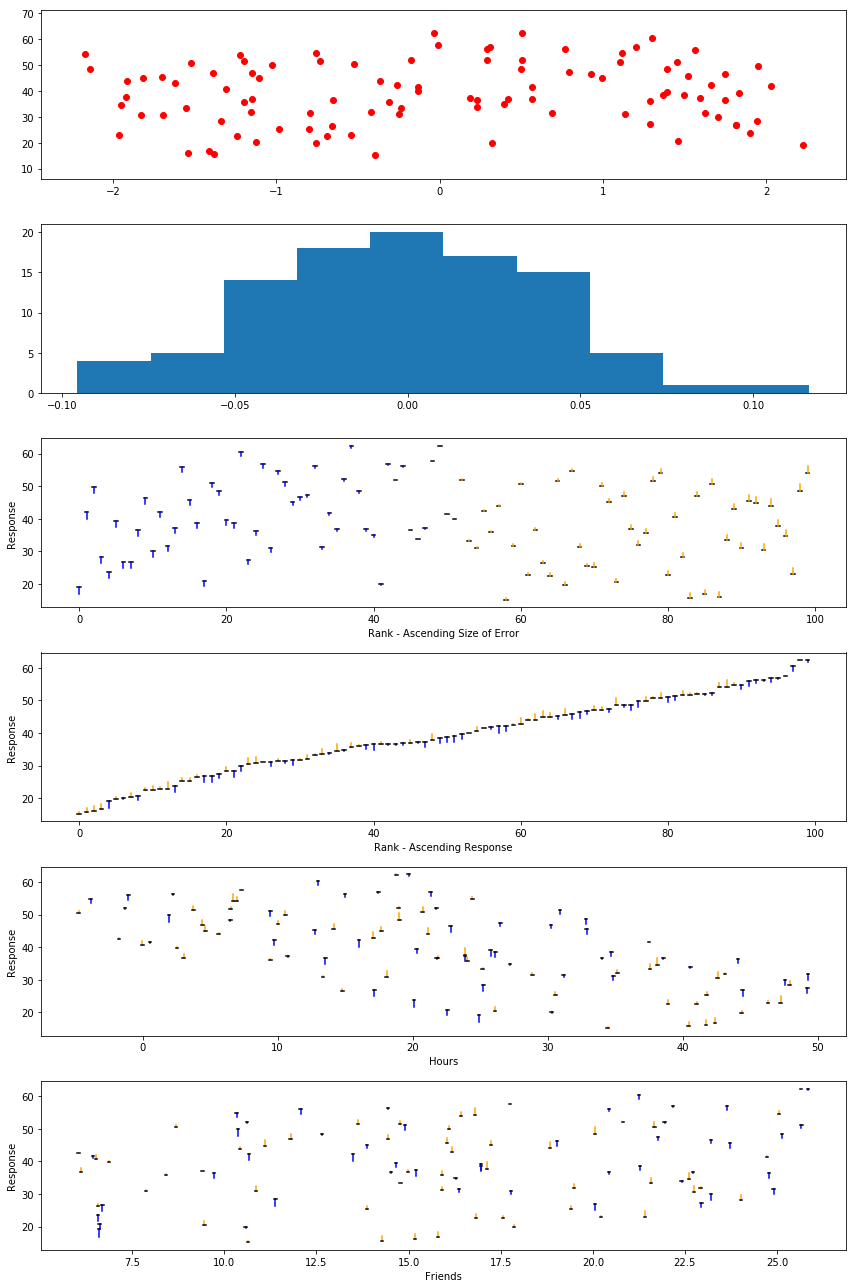

In [5]:
import numpy as np

calc_betas = [28.44779644819599, 2.061322520577637, -1.0093169522768661]


normal_errors = [(y - predict(x_i, calc_betas))/y for x_i, y in zip(data, ys)]
residuals = [(y - predict(x_i, calc_betas)) for x_i, y in zip(data, ys)]
abs_errors = [np.abs(y - predict(x_i, calc_betas))/y for x_i, y in zip(data, ys)]

fig,axs = plt.subplots(6)

ax1, ax2, ax3, ax4,ax5, ax6 = axs

for res, y in zip(residuals,ys):
    ax1.scatter(res,y, color = "red")
    
ax2.hist(normal_errors)


predictions = [predict(x_i, calc_betas) for x_i in data]
indices = [i+1 for i in range(len(ys))]

for i, (pred, y) in enumerate(sorted(zip(predictions, ys),key = lambda (y,z): y-z)):
    ax3.plot([i-0.25,i+0.25],[y,y],color = "black")
    if pred > y:
        ax3.plot([i,i],[y,pred],color = "orange")  
    else:
        ax3.plot([i,i],[y,pred],color = "blue")

ax3.set(ylabel = "Response", xlabel = "Rank - Ascending Size of Error")


for i, (pred, y) in enumerate(sorted(zip(predictions, ys),key = lambda (_,y): y)):
    if pred > y:
        ax4.plot([i,i],[y,pred],color = "orange")  
    else:
        ax4.plot([i,i],[y,pred],color = "blue")
    ax4.plot([i-0.25,i+0.25],[y,y],color = "black")
    
ax4.set(ylabel = "Response", xlabel = "Rank - Ascending Response")

for i, (pred, y,work) in enumerate(sorted(zip(predictions, ys, work_hours),key = lambda (_,y,__): y)):
    if pred > y:
        ax5.plot([work,work],[y,pred],color = "orange")  
    else:
        ax5.plot([work,work],[y,pred],color = "blue")
    ax5.plot([work-0.1,work+0.1],[y,y],color = "black")
    
ax5.set(ylabel = "Response", xlabel = "Hours")

for i, (pred, y, friend) in enumerate(sorted(zip(predictions, ys,friends_count),key = lambda (_,y,__): y)):
    if pred > y:
        ax6.plot([friend,friend],[y,pred],color = "orange")  
    else:
        ax6.plot([friend,friend],[y,pred],color = "blue")
    ax6.plot([friend-0.03,friend+0.03],[y,y],color = "black")
    
ax6.set(ylabel = "Response", xlabel = "Friends")
        
fig.set_size_inches(12, 18)
plt.tight_layout()
plt.show()
   

In the second panel it's clear that the errors of the model are normally distributed and centred on 0. This seems good. Ideally, we'd make the range of the error size smaller though, 10% each way seems like a lot. 

Now let's try to make a model using only the friends parameter and see what happens!


In [6]:
data2 = [(x,y) for x,y,_ in data]

print minimise_stochastic(sum_of_squares_i, sum_of_squares_gradient_i, data2, ys , [2,20], alpha_0=0.00001)

[30.65147710451467, 0.5110078617970937]


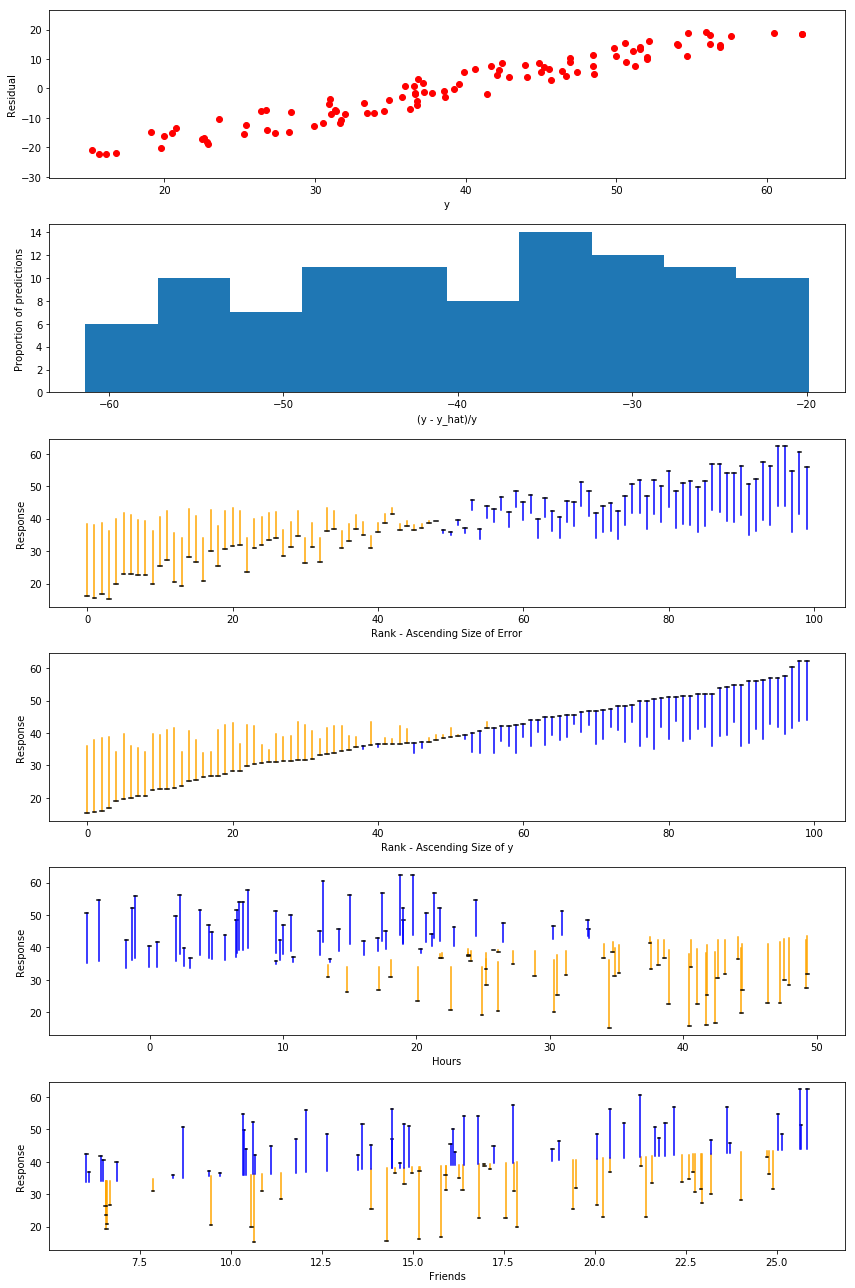

In [8]:
calc_betas = [30.627760931737626, 0.5132761810265215]

normal_errors = [(y - predict(x_i, calc_betas)-np.mean(ys) ) for x_i, y in zip(data2, ys)]
residuals = [(y - predict(x_i, calc_betas)) for x_i, y in zip(data2, ys)]
abs_errors = [np.abs(y - predict(x_i, calc_betas))/y for x_i, y in zip(data2, ys)]

fig,axs = plt.subplots(6)

ax1, ax2, ax3, ax4,ax5, ax6 = axs

for res, y in zip(residuals,ys):
    ax1.scatter(y,res, color = "red")

ax1.set(ylabel = "Residual", xlabel = "y")

ax2.hist(normal_errors)

ax2.set(ylabel = "Proportion of predictions", xlabel = "(y - y_hat)/y")

predictions = [predict(x_i, calc_betas) for x_i in data2]
indices = [i+1 for i in range(len(ys))]

for i, (pred, y) in enumerate(sorted(zip(predictions, ys),key = lambda (y,z): z-y)):
    if pred > y:
        ax3.plot([i,i],[y,pred],color = "orange")  
    else:
        ax3.plot([i,i],[y,pred],color = "blue")
    ax3.plot([i-0.25,i+0.25],[y,y],color = "black")

ax3.set(ylabel = "Response", xlabel = "Rank - Ascending Size of Error")


for i, (pred, y) in enumerate(sorted(zip(predictions, ys),key = lambda (_,y): y)):
    if pred > y:
        ax4.plot([i,i],[y,pred],color = "orange")  
    else:
        ax4.plot([i,i],[y,pred],color = "blue")
    ax4.plot([i-0.25,i+0.25],[y,y],color = "black")

ax4.set(ylabel = "Response", xlabel = "Rank - Ascending Size of y")

for i, (pred, y,work) in enumerate(sorted(zip(predictions, ys, work_hours),key = lambda (_,y,__): y)):
    if pred > y:
        ax5.plot([work,work],[y,pred],color = "orange")  
    else:
        ax5.plot([work,work],[y,pred],color = "blue")
    ax5.plot([work-0.1,work+0.1],[y,y],color = "black")

ax5.set(ylabel = "Response", xlabel = "Hours")

for i, (pred, y, friend) in enumerate(sorted(zip(predictions, ys,friends_count),key = lambda (_,y,__): y)):
    if pred > y:
        ax6.plot([friend,friend],[y,pred],color = "orange")  
    else:
        ax6.plot([friend,friend],[y,pred],color = "blue")
    ax6.plot([friend-0.03,friend+0.03],[y,y],color = "black")

ax6.set(ylabel = "Response", xlabel = "Friends")

fig.set_size_inches(12, 18)
plt.tight_layout()
plt.show()

Let's look at this stuff I decided to chart and see if there anything meaningful here.
We're using raw error, maybe it should be the size of the error proportional to the distance from the mean?

Interpretation: 

Chart 1: The residuals increase linearly as y increases. We know that this model is missing a variable compared to the "true" model.

Chart 2: The distribution of residuals is fairly normal.




The model we created is:

\begin{equation}
\hat y  = 30.63 + 0.51 \cdot \textit{friends}
\tag{1}
\end{equation}

where the "true model" is:

\begin{equation}
y = 26 + 2 \cdot\textit{friends} - \textit{work hours}
\end{equation}

In $(1)$, the number of friends is underweighted by a factor of $4$, so that $y$ only increases by a quarter of what it should as $\textit{friends}$ increases. 

Why did the single variable model underweight $\textit{friends}$?

Recall that friends and work hours are positively correlated. This means that larger values of friends tend to occur with larger values of work hours. Recall also that work hours and minutes are negatively correlated, so that more work hours means less minutes on the site. In this case we can approximately describe the relationship, and so can calculate the resulting transaction of minutes:
\begin{equation}
\textit{work hours} \propto 1.5\cdot \textit{friends},
\end{equation}
and 
\begin{equation}
\textit{minutes}  \propto 2 \cdot\textit{friends} - \textit{work hours},
\end{equation}
so $1$ additional friend should translate to $2\cdot 1 - 1.5\cdot 1 = 0.5$ additional minutes, which is approximately 
the relationship captured in the single variable model. 

I expect that the existence of this relationship implies that the model is not substantially improved by the addition of the work_hours variable and is about equally good using just the work_hours instead of the friends count. The prediction is however quite a bit better when two variables are used, because the built-in noise from the relationship between hours and friends is lost when hours is ignored.


The degree to which variables subject to inclusion in a model may be substituted or ignored is the degree to which they are correlated.

How to evaluate a Regression model

1. Residual plots

Simply plot $y_i - \hat y_i$ against $y$ on the x-axis, any non-randomness in the residual plot (e.g. differences in variance as a function of y) can indicate a missing feature in your model. Ideally, you want the spread of residuals to be independent of y and roughly normally distributed in value.

2. RMSE and MAE

Root mean square error - 

\begin{equation}
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat y_i)^2}
\end{equation}

Penalises large errors severely. Can be efficiently calculated as $\sqrt{1-r^2} SD_y$, where $r$ is the correlation of $y$ and $SD$ is the standard deviation.

Mean absolute error - 

\begin{equation}
MAE = \frac{1}{n} \sum_{i=1}^n \mid y_i - \hat y_i \mid
\end{equation}

